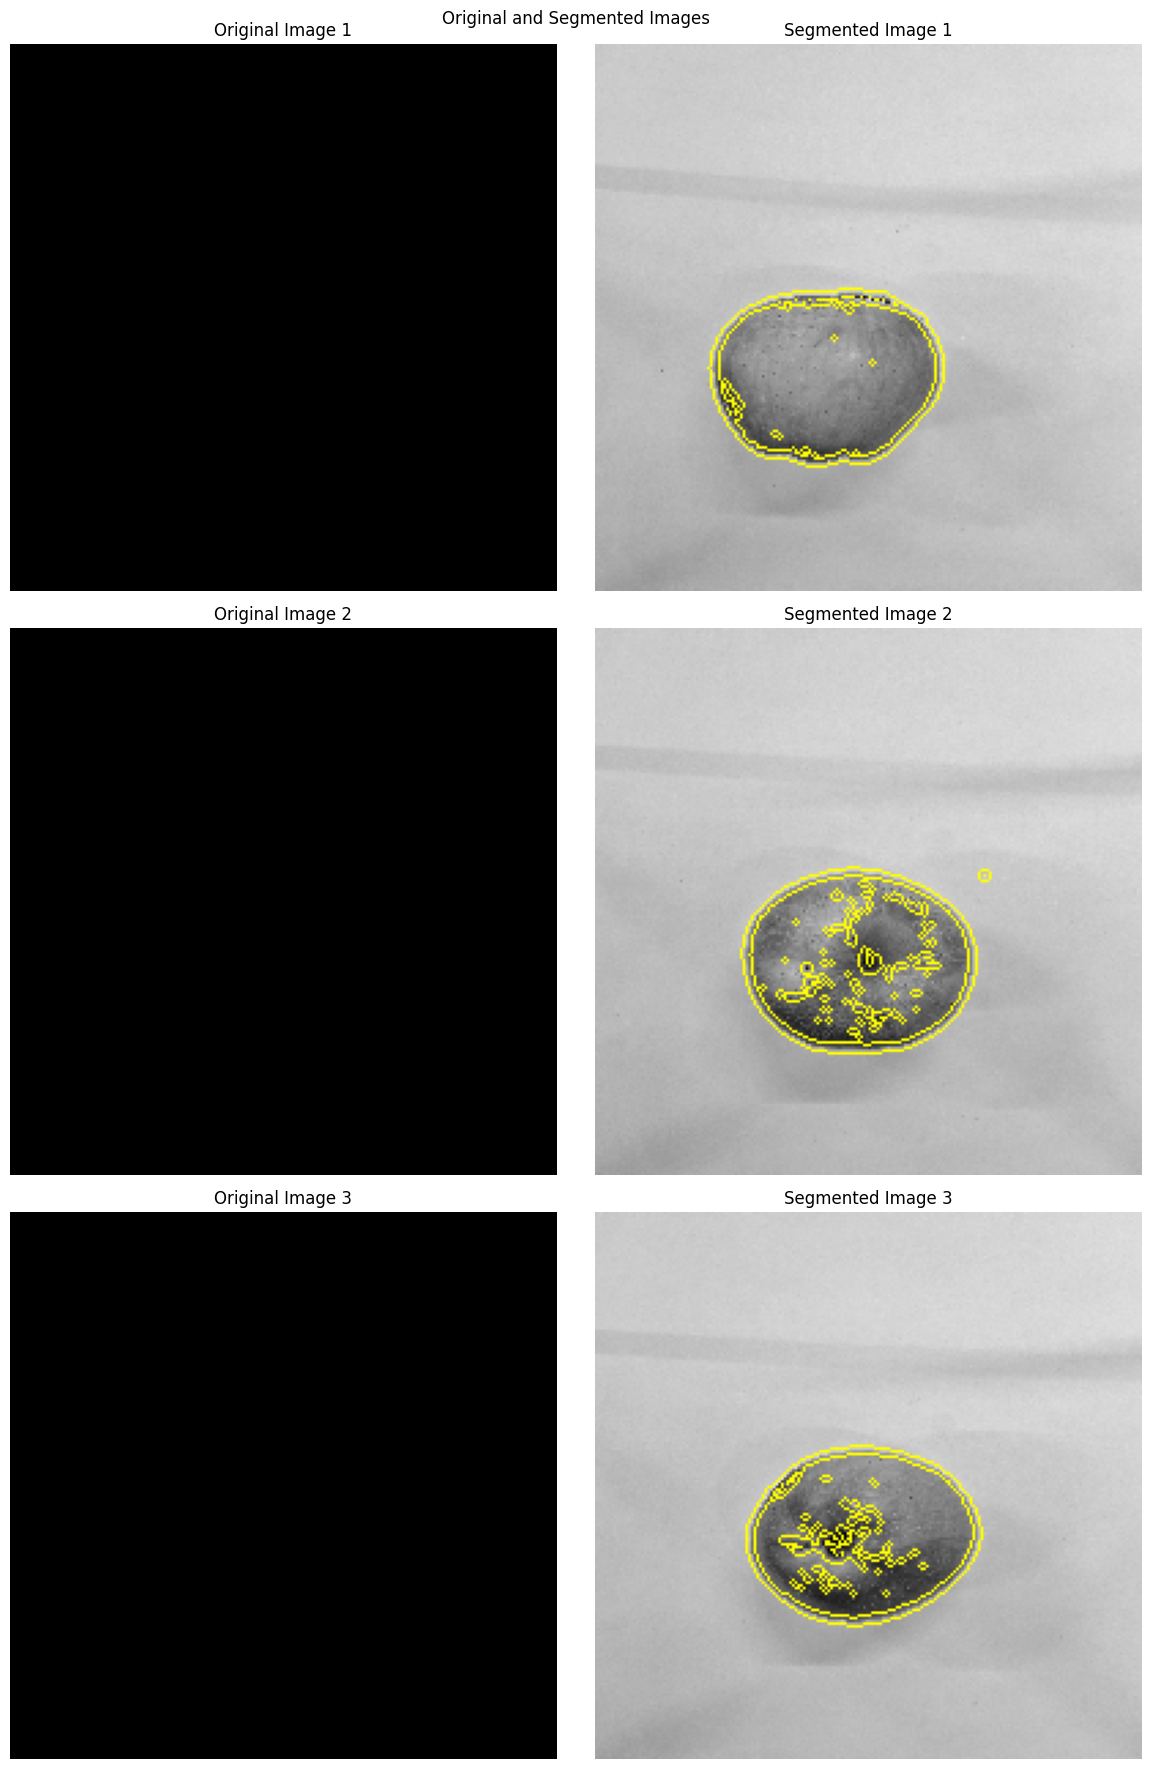

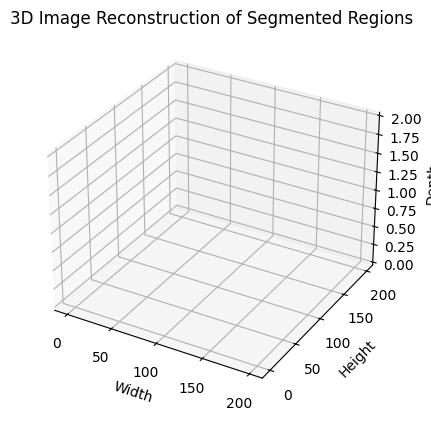

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import color, segmentation, filters

# Function to load and preprocess 2D images
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = tf.io.decode_image(tf.io.read_file(path), channels=3, dtype=tf.float32)
        img = tf.image.resize(img, [200, 200])  # Resize for consistency (adjust size as needed)
        images.append(img)
    return images

# Function to perform segmentation on an image
def segment_image(image):
    # Convert image to grayscale
    gray_image = color.rgb2gray(image.numpy())
    
    # Apply edge-based segmentation (using Canny edge detector)
    edges = filters.sobel(gray_image)
    segmented_image = segmentation.mark_boundaries(gray_image, edges > 0.1)
    
    return segmented_image

# Image paths
image_paths = ["./images/3a.jpg", "./images/3b.jpg", "./images/3c.jpg"]

# Load and preprocess images
images = load_images(image_paths)

# Plot original and segmented images in a grid layout
num_images = len(images)
plt.figure(figsize=(12, 6 * num_images))

for i, image in enumerate(images):
    # Original image
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')
    
    # Segmented image
    segmented_image = segment_image(image)
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(segmented_image, cmap='gray')
    plt.title(f'Segmented Image {i + 1}')
    plt.axis('off')

plt.suptitle('Original and Segmented Images')
plt.tight_layout()
plt.show()

# Stack segmented images along a new dimension to create a 3D tensor
segmented_stack = tf.stack([segment_image(image) for image in images], axis=0)

# Visualize the 3D reconstruction of segmented images
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each slice of the 3D segmented image stack
depth = segmented_stack.shape[0]
for i in range(depth):
    x = np.arange(segmented_stack[i].shape[1])
    y = np.arange(segmented_stack[i].shape[0])
    X, Y = np.meshgrid(x, y)
    
    # Use i as a contour level to distinguish slices
    Z = np.ones_like(X) * i
    
    # Get the segmented 2D slice from the 3D tensor
    slice_image = segmented_stack[i].numpy()
    
    # Plot as contour with appropriate contour levels
    levels = np.linspace(0, 1, 10)  # Define contour levels from 0 to 1
    ax.contour3D(X, Y, Z, slice_image, cmap='gray', levels=levels)

# Set axis labels
ax.set_xlabel('Width')
ax.set_ylabel('Height')
ax.set_zlabel('Depth')

plt.title('3D Image Reconstruction of Segmented Regions')
plt.show()


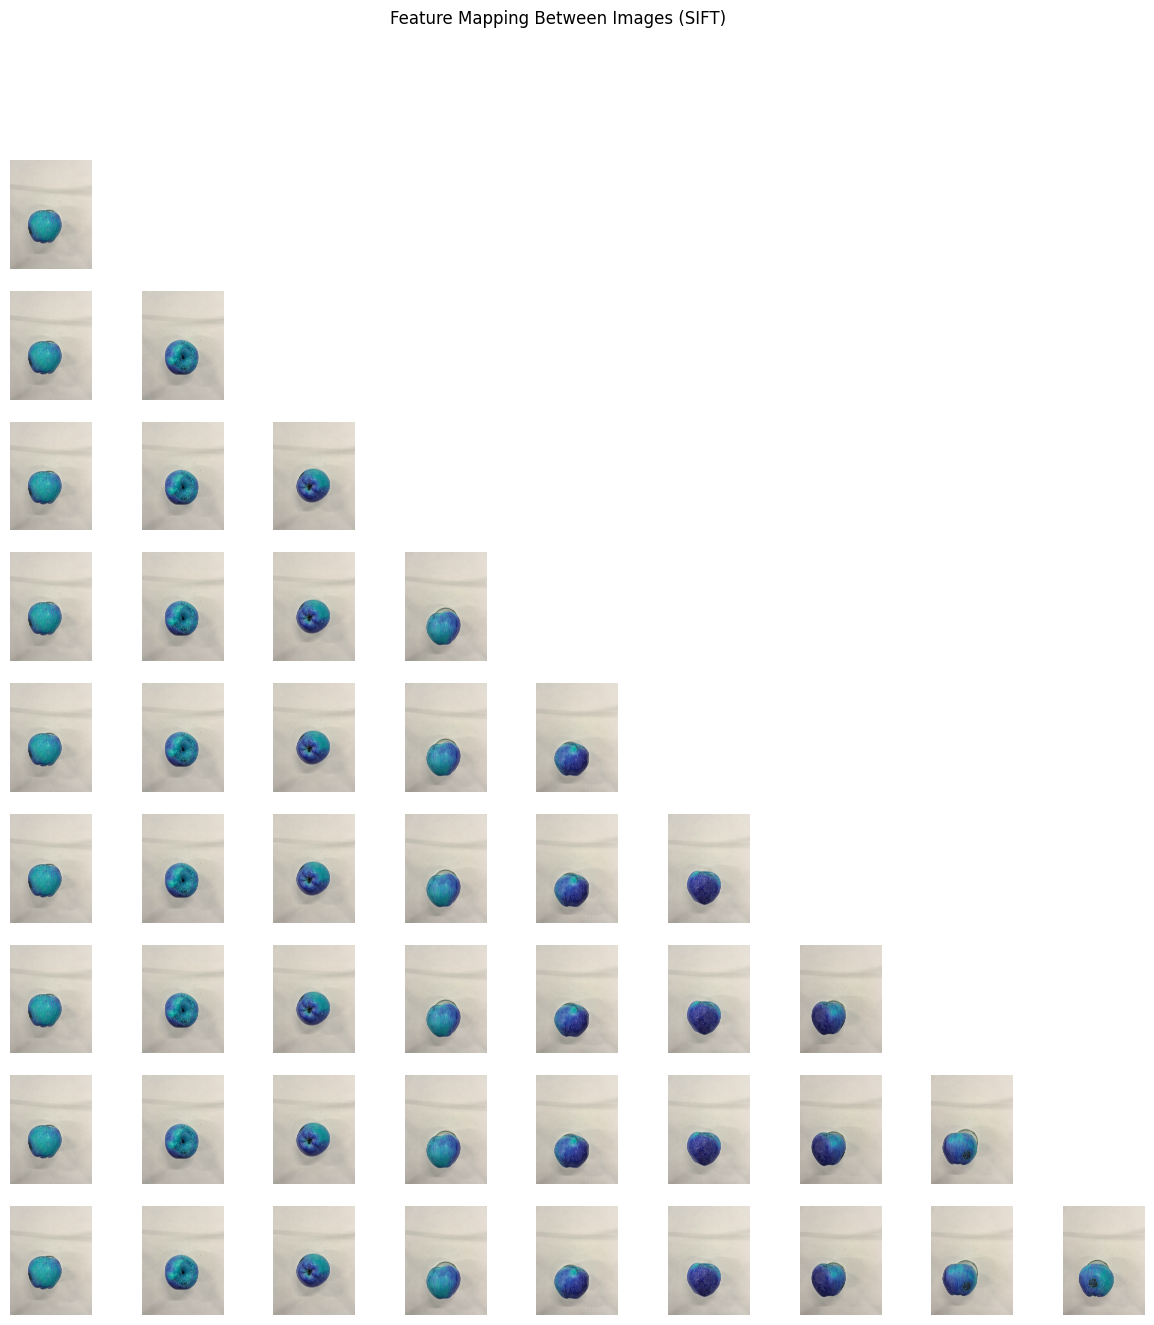

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

common_path = './images/'
# Load images
image_paths = [common_path+'3a.jpg', common_path+'3b.jpg', common_path+'3c.jpg', common_path+'3d.jpg', common_path+'3e.jpg',common_path+'3f.jpg',common_path+'3g.jpg',common_path+'3h.jpg',common_path+'3i.jpg']
images = [cv2.imread(path) for path in image_paths]

# Convert images to grayscale
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Initialize FLANN matcher
flann_index_params = dict(algorithm=1, trees=5)
flann_search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(flann_index_params, flann_search_params)

# List to store keypoints and descriptors
keypoints_list_sift = []
descriptors_list_sift = []

# Extract keypoints and descriptors from all images
for gray in gray_images:
    # SIFT
    keypoints_sift, descriptors_sift = sift.detectAndCompute(gray, None)
    keypoints_list_sift.append(keypoints_sift)
    descriptors_list_sift.append(descriptors_sift)

# Match keypoints between pairs of images
matches_list_sift = []

for i in range(len(images)):
    for j in range(i + 1, len(images)):
        descriptors_i_sift = descriptors_list_sift[i]
        descriptors_j_sift = descriptors_list_sift[j]

        # Match descriptors using FLANN (SIFT)
        matches_sift = flann.knnMatch(descriptors_i_sift, descriptors_j_sift, k=2)

        # Apply ratio test to filter good matches (SIFT)
        good_matches_sift = []
        for m, n in matches_sift:
            if m.distance < 0.7 * n.distance:
                good_matches_sift.append(m)

        # Store matches (SIFT)
        matches_list_sift.append((i, j, good_matches_sift))

# Visualize feature mappings between each pair of images
fig, axes = plt.subplots(len(images), len(images), figsize=(15, 15))

for i in range(len(images)):
    for j in range(len(images)):
        if i == j:
            axes[i, j].imshow(images[i])
            axes[i, j].axis('off')
        elif i < j:
            axes[i, j].remove()
        else:
            axes[i, j].imshow(images[j])
            axes[i, j].axis('off')

for i, j, matches in matches_list_sift:
    img1 = images[i]
    img2 = images[j]
    kp1 = keypoints_list_sift[i]
    kp2 = keypoints_list_sift[j]

    # Draw matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Create connection between images
    con = ConnectionPatch(xyA=(0, 0), xyB=(1, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=axes[i, j], axesB=axes[j, i], color="red")
    axes[i, j].add_artist(con)

    # Display match image in appropriate subplot
    if i < j:
        axes[i, j].imshow(match_img)
        axes[i, j].axis('off')

plt.suptitle('Feature Mapping Between Images (SIFT)')
plt.show()